In [ ]:
# default_exp core

## Simple funnel plots in Python

This module plots funnel plots, to highlight outliers in sub-group variations versus population variations.


In [ ]:
from nbdev.showdoc import *

In [ ]:
#export
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

In [ ]:
%matplotlib inline

In [ ]:
#export
def ci_width(group_size, band):
        return band / np.sqrt(group_size)    

In [ ]:
# export
def expand_bbox(bbox, pct):
    """
    Given a matplotlib Bbox, return a bounding box centered on the same location,
    but expanded/contracted by `pct`, which should be a floating point factor.
    `pct=1.0` means the bounding box is unchanged; `pct=2.0` means doubling the size
    in width and height, etc.
    """
    w, h = bbox.x1 - bbox.x0, bbox.y1 - bbox.y0
    cx, cy = (bbox.x0 + bbox.x1) / 2, (bbox.y0 + bbox.y1) / 2

    return Bbox.from_bounds(cx - (w * pct) / 2, cy - (h * pct) / 2, w * pct, h * pct)

In [ ]:
# export
def annotate_label(ax, x, y, s, bboxs, left=False):
    """Annotate a point `x,y` with the string `s`.
    Avoid overlapping any of the bounding boxes in `bboxs` *and*
    add the new bounding box for this element to `bboxs`. 
    If `left` draw the label to the left; otherwise to the right of the given
    point."""
    x_offset = 0.5
    y_offset = 1.0
    align = "right" if left else "left"
    found_good_placement = False

    while not found_good_placement:
        x_offset += 0.5
        y_offset += 1
        x_off = x_offset * (-1 if left else 1)
        ann = ax.text(
            x + x_off,
            y + y_offset,
            s,
            verticalalignment="center",
            horizontalalignment=align,
            alpha=0.5,
        )
        bbox = expand_bbox(ann.get_window_extent(ax.figure.canvas.get_renderer()), 1.05)

        found_good_placement = not any([b.overlaps(bbox) for b in bboxs])
        if not found_good_placement:
            ann.remove()
    # breakline plot
    ax.plot(
        [x + x_off * 0.95, x + x_off * 0.35, x],
        [y + y_offset, y + y_offset, y],
        alpha=0.1,
        c="k",
    )
    bboxs.append(bbox)

In [ ]:
# export


def funnel_plot(
    data_groups,
    ax=None,
    dist=scipy.stats.norm(0, 1),
    bootstrap=True,
    percentage=97.5,
    labels=None,
    left_color="C1",
    right_color="C2",
    show_contours=True,
):
    """
    Produce a funnel plot of data_groups, with std. err. bounds at the given percentile.
    Fits using the given distribution (usually normal distribution).
    
    Note: will be  slow for many groups, as the bootstrap is run for every 
    group size to compute the bounds curves.
    
    Parameters:
        data_groups: list of 1D arrays
            a list of 1D arrays the individual groups to be analysed.
        ax: axis, optional
            an Matplotlib axis to draw onto
        dist: distribution function, like scipy.stats.norm(0,1)
            function to use to get the ppf and cdf of for plotting
        percentage: float, 0.0 -> 100.0 (default 97.5)
            the cutoff to use for the funnel on each side; for example 97.5 will enclose 95%
        labels: list of strings, optional
            one label string per group, will be shown only for those groups that lie outside the funnel
        left_color: matplotlib color, optional (default C1)
            color to render points to the left of the funnel bounds (negative outliers)
        right_color: matplotlib color, optional (default C2)
            color to render points to the right of the funnel bounds (positive outliers)
        bootstrap: boolean, optional (default True)
            If True, show the error in markers using a dot plot of bootstrap draws; otherwise, show
            the actual data points.            
        show_contours: boolean optional (default True)
            true if additional contours shown
        
    """

    ppf = dist.ppf
    cdf = dist.cdf

    percentage = percentage / 100.0
    if ax is None:
        ax = plt.gca()

    band = ppf(percentage)

    groups = sorted(data_groups, key=lambda x: len(x))

    # draw the funnel
    max_group_len = max(*[len(g) for g in groups])
    ys = np.linspace(0, max_group_len + 1, 100)

    if show_contours:
        for pf in [0.5, 0.75, 0.9, 0.99, 0.99, 0.999, 0.9999, 0.99999, 0.999999]:
            ci = ci_width(ys, ppf(pf))
            ax.plot(ci, ys, "k", lw=0.1)
            ax.plot(-ci, ys, "k", lw=0.1)

    # main funnel bands
    ci = ci_width(ys, band)
    ax.plot(ci, ys, "k", alpha=1.0)
    ax.plot(-ci, ys, "k", alpha=1.0)
    
    ax.set_xlim(-ci[1], ci[1])

    # combine into one population group
    pop_group = np.concatenate(data_groups, axis=0)
    pop_mean, pop_std = np.mean(pop_group), np.std(pop_group)

    bboxs = []

    # draw each group
    for i, group in enumerate(groups):
        mean, std = np.mean(group), np.std(group)
        dev = (mean - pop_mean) / pop_std

        l = len(group)
        span = ci_width(l, ppf(percentage))
        if -span < dev < span:
            ax.plot(dev, l, "k.")
        else:
            left = dev < 0
            if labels:
                annotate_label(ax, dev, len(group), labels[i], bboxs, left=left)
            if left:
                color = left_color

            else:
                color = right_color

            ax.plot(dev, len(group), color, marker="o")
            if bootstrap:
                devs = [
                    (
                        np.mean(np.random.choice(group, replace=True, size=len(group)))
                        - pop_mean
                    )
                    / pop_std
                    for i in range(100)
                ]
                ax.scatter(
                    devs,
                    np.tile(len(group), (len(devs))),
                    alpha=0.1,
                    zorder=-2,
                    c=color,
                    s=2,
                )

    ax.axvline(0.0, c="k", alpha=0.2)

    # force limit to be symmetrical    
    
    ax.set_xlim(-ppf(0.99), ppf(0.99))
    
    ax.set_xlabel("Z score")
    ax.set_ylabel("Group size")

## `funnel_plot`

Creates a funnel plot for a given set of data_groups, which should be a iterable of groups (e.g. as returned by Pandas `groupby()`). `percentage` sets the threshold for the funnel "notability" cutoff, that is, the confidence interval that is plotted. `labels` can optionally be a sequence of names the same length as `data_groups` which are the names of each group. Groups falling *outside* the funnel will be labeled with annotations if `labels` is present.

## Simple test

In [ ]:
groups = []
p_mean, p_std = 0, 1
for i in range(25):
    n_group = np.random.randint(1, 80)
    g_std =  np.random.uniform(0.1, 4.5) 
    g_mean = np.random.uniform(-1.9, 0.5)
    groups.append(np.random.normal(p_mean + g_mean,
                                   p_std + g_std, 
                                   n_group))

c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


1.959963984540054


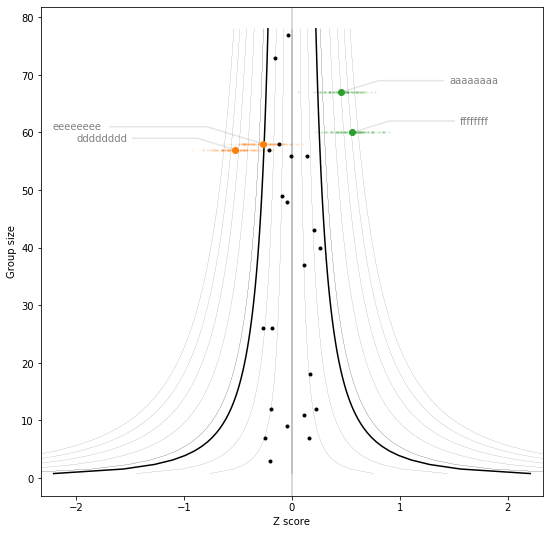

In [ ]:
import random

ax, fig = plt.subplots(figsize=(9, 9))
funnel_plot(
    groups,
    labels=[random.choice("abcdefg") * 8 for i in range(len(groups))],
    percentage=97.5,
)

In [ ]:
# export
def bootstrap(data, stat, n, size=None):
    if size is None:
        size = len(data)
    return [stat(np.random.choice(data, replace=True, size=size)) for i in range(n)]

# export
def funnel_plot_bootstrap(
    data_groups,
    ax=None,
    percentage=97.5,
    labels=None,
    left_color="C1",
    right_color="C2",
    bootstrap_n=1000,
    show_contours=True,
    stat=np.mean,
):
    """
    Produce a funnel plot of data_groups, with std. err. bounds at the given percentile.
    Uses the bootstrap, instead of a normal fit, to estimate the confidence intervals.
    
    Note: will be  slow for many groups, as the bootstrap is run for every 
    group size to compute the bounds curves.
    
    Parameters:
        data_groups: list of 1D arrays
            a list of 1D arrays the individual groups to be analysed.
        ax: axis, optional
            an Matplotlib axis to draw onto
        percentage: float, 0.0 -> 100.0 (default 97.5)
            the cutoff to use for the funnel on each side; for example 97.5 will enclose 95%
        labels: list of strings, optional
            one label string per group, will be shown only for those groups that lie outside the funnel
        left_color: matplotlib color, optional (default C1)
            color to render points to the left of the funnel bounds (negative outliers)
        right_color: matplotlib color, optional (default C2)
            color to render points to the right of the funnel bounds (positive outliers)
        bootstrap_n: int, optional (default 1000)
            number of runs in the bootstrap
        show_contours: boolean optional (default True)
            true if additional contours shown
        stat: function like np.mean, optional
            statistic to use when plotting the funnel plot                                
    """

    if ax is None:
        ax = plt.gca()

    groups = sorted(data_groups, key=lambda x: len(x))

    # combine into one population group
    pop_group = np.concatenate(data_groups, axis=0)
    bboxs = []

    #ks = np.arange(1, len(groups[-1]) + 2)
    # include exact ks for the actual groups 
    
    ks = sorted([len(group) for group in data_groups])
    
    spread_k = np.array([bootstrap(pop_group, stat, n=bootstrap_n, size=k) for k in ks])
    lefts = np.percentile(spread_k, 100 -  percentage, axis=1)
    rights = np.percentile(spread_k,  percentage, axis=1)
    
    funnel_ks = np.linspace(1, len(groups[-1])+2, 50).astype(np.int32)
    funnel_strap = np.array([bootstrap(pop_group, stat, n=bootstrap_n, size=k) for k in funnel_ks])
    
    if show_contours:
        for pf in [0.5, 0.75, 0.9, 0.99, 0.99, 0.999, 0.9999, 0.99999, 0.999999]:
            l = np.percentile(funnel_strap, 100 - 100 * pf, axis=1)
            r = np.percentile(funnel_strap, 100 * pf, axis=1)
            ax.plot(l, funnel_ks, "k", lw=0.1)
            ax.plot(r, funnel_ks, "k", lw=0.1)

    # main funnel
    l = np.percentile(funnel_strap, 100 - percentage, axis=1)
    r = np.percentile(funnel_strap, percentage, axis=1)
    ax.plot(l, funnel_ks, "k")
    ax.plot(r, funnel_ks, "k")

    for i, group in enumerate(groups):
        means = bootstrap(group, stat, n=bootstrap_n)
        mean = stat(group)

        l = len(group)

        if lefts[i] < mean < rights[i]:
            ax.plot(mean, l, "k.")
        else:
            left = mean < lefts[i]
            if labels:
                annotate_label(ax, mean, len(group), labels[i], bboxs, left=left)
            if left:
                color = left_color

            else:
                color = right_color

            ax.plot(mean, len(group), color, marker="o")
            ax.plot(
                [np.percentile(means, 2.5), np.percentile(means, 97.5)],
                [len(group), len(group)],
                color,
            )

    ax.axvline(stat(pop_group), c="k", alpha=0.2)
    # force limit to be symmetrical 1% to 99%    
    ax.set_xlim(np.percentile(funnel_strap[0,:], 1), np.percentile(funnel_strap[0,:], 99))
    ax.set_xlabel("Value")
    ax.set_ylabel("Group size")

    

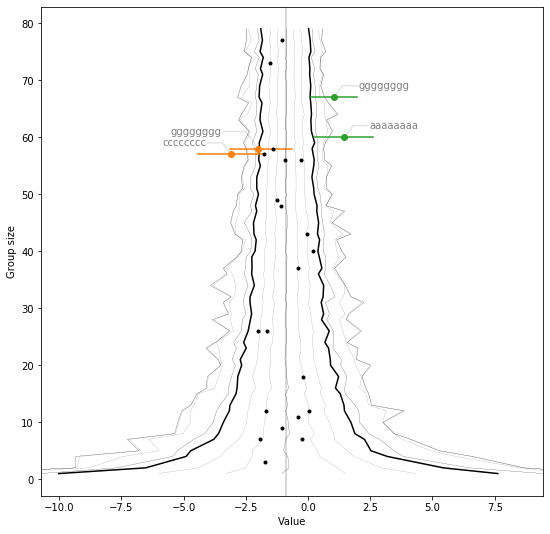

In [ ]:
ax, fig = plt.subplots(figsize=(9, 9))
funnel_plot_bootstrap(
    groups,
    labels=[random.choice("abcdefg") * 8 for i in range(len(groups))],
    stat=np.mean,
)

1.959963984540054


c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


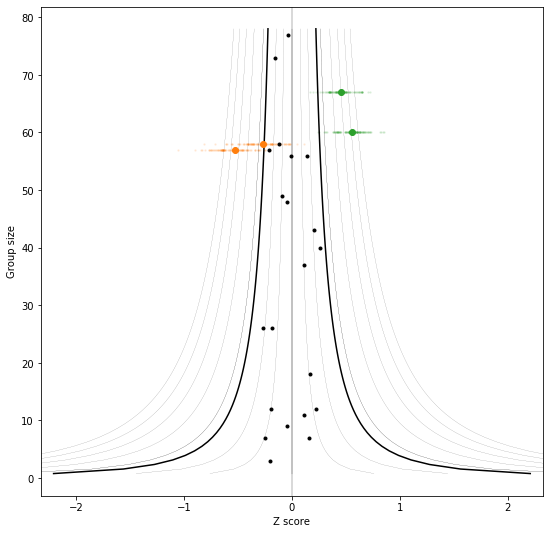

In [ ]:
ax, fig = plt.subplots(figsize=(9,9))
funnel_plot(groups,            
            percentage=97.5
           )   

2.3263478740408408

c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


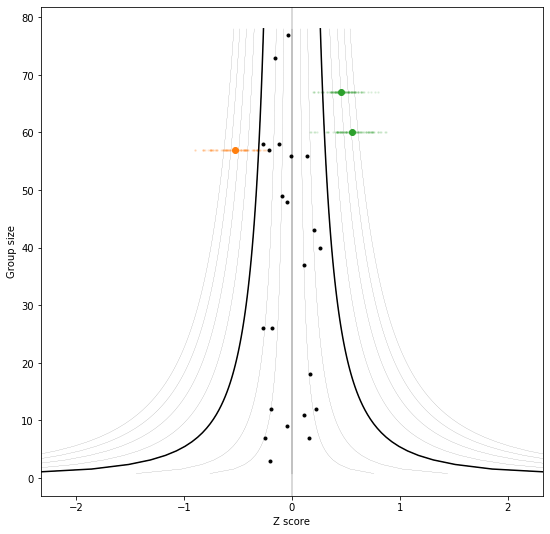

In [ ]:
ax, fig = plt.subplots(figsize=(9,9))
funnel_plot(groups,            
            percentage=99.0
           )   

1.959963984540054


c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


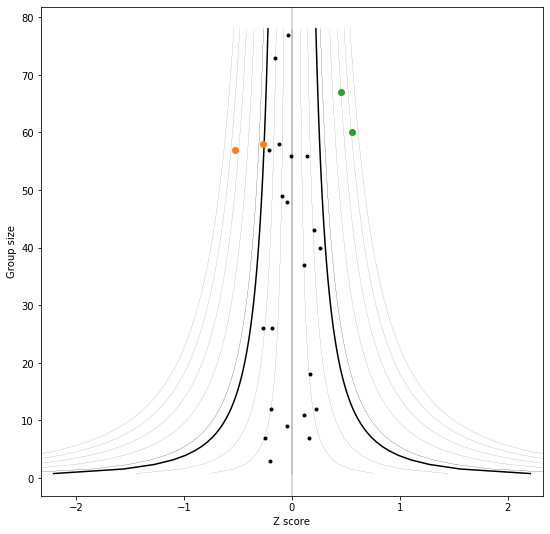

In [ ]:
ax, fig = plt.subplots(figsize=(9,9))
funnel_plot(groups,            
            percentage=97.5,
            bootstrap=False
           )   

1.2815515655446004


c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


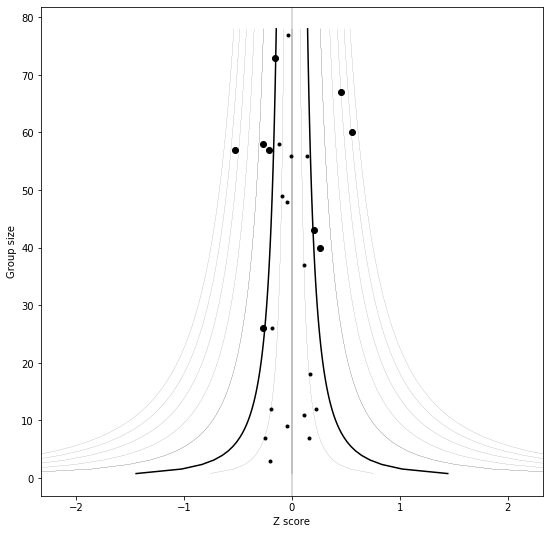

In [ ]:
ax, fig = plt.subplots(figsize=(9,9))
funnel_plot(groups,            
            left_color='k', right_color='k',
            percentage=90.0,
            bootstrap=False
           )   

In [ ]:
# export
def funnel(df, x, group, bootstrap_mode=False, **kwargs):
    """Apply the funnel plot to a dataframe, grouping elements by "group" and showing column "x" of the data.
    Parameters:
        df: DataFrame
            The data to be shown.
        x:  string, column name
            The column of the frame to render as datapoints.
        group: string, column name
            The column to group the frame by
        bootstrap_mode: boolean, optional (default False)
            If True, uses the funnel_plot_bootstrap() function; otherwise
            use the parameteric funnel_plot() function
        **kwargs:
            passed to funnel_plot() / funnel_plot_bootstrap()
    """
    grouped = df.groupby(group)
    labels = []
    datas = []
    for group, data in grouped:
        labels.append(group)
        datas.append(np.array(data[x]))
        
        
    if bootstrap_mode:
        funnel_plot_bootstrap(data_groups=datas, labels=labels, **kwargs)
    else:
        funnel_plot(data_groups=datas, labels=labels, **kwargs)
    

c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
c:\local\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


1.959963984540054


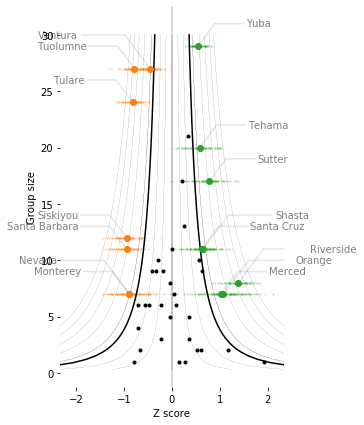

In [ ]:
import pandas as pd
from pydataset import data
fig,ax = plt.subplots(figsize=(4,7))
ax.set_frame_on(False)
funnel(df=data("Caschool"), x='testscr', group="county")
plt.savefig("imgs/caschool_example.png", bbox_inches="tight", dpi=120)

In [ ]:
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted index.ipynb.
